Epoch 1, Training Loss: 0.6371
Epoch 2, Training Loss: 0.3312
Epoch 3, Training Loss: 0.1879
Epoch 4, Training Loss: 0.1445
Epoch 5, Training Loss: 0.1367
MAE = 0.6111518740653992
RMSE = 0.7891385258978191


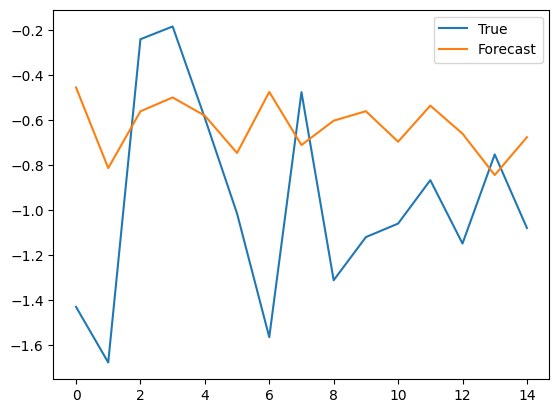

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

def generate_synthetic_dataset(T=1500, n_features=5, seed=42):
    np.random.seed(seed)
    t = np.arange(T)
    data = []

    for f in range(n_features):
        seasonal = 2 * np.sin(2 * np.pi * (0.003*(f+1)) * t + np.random.rand())
        trend = 0.001 * (f+1) * t
        noise = np.random.normal(0, 0.5 + 0.1*f, size=T)
        value = seasonal + trend + noise
        data.append(value)

    df = pd.DataFrame(np.array(data).T, columns=[f"feat_{i}" for i in range(n_features)])
    return df

df = generate_synthetic_dataset()
df.head()

class TimeSeriesWindow(Dataset):
    def __init__(self, data, input_len=60, target_len=15):
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(data)

        self.X = []
        self.Y = []

        for i in range(len(data) - input_len - target_len):
            x_seq = self.data[i:i+input_len]
            y_seq = self.data[i+input_len:i+input_len+target_len]
            self.X.append(x_seq)
            self.Y.append(y_seq)

        self.X = np.array(self.X, dtype=np.float32)
        self.Y = np.array(self.Y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = TimeSeriesWindow(df.values)

total = len(dataset)

train_size = int(total*0.7)
val_size = int(total*0.15)
test_size = total - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000) / d_model))

        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)


class TransformerTS(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=2, target_len=15):
        super().__init__()
        self.target_len = target_len
        self.n_features = n_features

        self.input_proj = nn.Linear(n_features, d_model)
        self.pos = PositionalEncoding(d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, n_features * target_len)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos(x)
        enc = self.encoder(x)
        pooled = torch.mean(enc, dim=1)
        out = self.fc(pooled)
        return out.view(-1, self.target_len, self.n_features)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerTS(n_features=df.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_model(epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader):.4f}")

train_model(epochs=5)


def inverse_scale(data, scaler):
    return scaler.inverse_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

def evaluate(loader):
    model.eval()
    preds_all, true_all = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds_all.append(out)
            true_all.append(yb.numpy())

    preds_all = np.concatenate(preds_all)
    true_all = np.concatenate(true_all)

    preds_inv = inverse_scale(preds_all, dataset.scaler)
    true_inv = inverse_scale(true_all, dataset.scaler)

    mae = mean_absolute_error(true_inv.ravel(), preds_inv.ravel())
    # Calculate RMSE by taking the square root of MSE
    rmse = np.sqrt(mean_squared_error(true_inv.ravel(), preds_inv.ravel()))

    print("MAE =", mae)
    print("RMSE =", rmse)

    return preds_inv, true_inv

preds, truths = evaluate(test_loader)


sample = 2
feature = 0

plt.plot(truths[sample, :, feature], label="True")
plt.plot(preds[sample, :, feature], label="Forecast")
plt.legend()
plt.show()

